In [ ]:
import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm.notebook import tqdm




In [ ]:
# add kaggle.json file for Kaggle API
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"niksmsk","key":"b0257cced7bc68ee68d03e8b1975910f"}'}

In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
#downloading 7000 labeled pokemons dataset
!kaggle datasets download -d lantian773030/pokemonclassification


Dataset URL: https://www.kaggle.com/datasets/lantian773030/pokemonclassification
License(s): copyright-authors
100% 416M/417M [00:05<00:00, 41.9MB/s]
100% 417M/417M [00:05<00:00, 80.0MB/s]


In [ ]:
#unzip
!unzip pokemonclassification.zip


In [ ]:
!ls -la PokemonData/

In [ ]:
#loss and accuracy plots function

sns.set_style('whitegrid')
plt.rcParams.update({'font.size':15})

def plot_losses(train_losses, test_losses, train_accuracies, test_accuracies):
    clear_output()
    fig, axs = plt.subplots(1,2,figsize = (13,4))
    axs[0].plot(range(1, len(train_losses)+1), train_losses, label = 'train')
    axs[0].plot(range(1, len(test_losses)+1), test_losses, label = 'test')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accuracies)+1), train_accuracies, label = 'train')
    axs[1].plot(range(1, len(test_accuracies)+1), test_accuracies, label = 'test')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()


In [ ]:
def training_epoch(model, oprimizer, criterion, train_loader, tqdm_desc):
    train_loss, train_accuracy = 0.0, 0.0
    model.train()
    for images, labels in tqdm(train_loader, desc=tqdm_desc):
        images = images.to(device)
        labels = labels.to(device)

        oprimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.shape[0]
        train_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    return train_loss, train_accuracy

@torch.no_grad()
def validation_epoch(model, criterion, test_loader, tqdm_desc):
    test_loss, test_accuracy = 0.0, 0.0
    model.eval()
    for images, labels in tqdm(test_loader, desc=tqdm_desc):
        images = images.to(device)
        labels = labels.to(device)
        logits = model(images)
        loss = criterion(logits, labels)


        test_loss += loss.item() * images.shape[0]
        test_accuracy += (logits.argmax(dim=1) == labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy /= len(test_loader.dataset)
    return test_loss, test_accuracy


In [ ]:
def train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs):
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = training_epoch(model, optimizer, criterion, train_loader, tqdm_desc = f'Training {epoch}/{num_epochs}')
        test_loss, test_accuracy = validation_epoch(model, criterion, test_loader, tqdm_desc = f'Validation {epoch}/{num_epochs}')


        if scheduler is not None:
            scheduler.step()


        train_losses += [train_loss]
        train_accuracies += [train_accuracy]
        test_losses += [test_loss]
        test_accuracies += [test_accuracy]
        plot_losses(train_losses, test_losses, train_accuracies, test_accuracies)

    return train_losses, test_losses, train_accuracies, test_accuracies

In [ ]:
#custom Dataset class
class PokemonDataset(Dataset):
    SPLIT_RANDOM_SEED = 42
    TEST_SIZE = 0.25

    def __init__(self, root, train=True, load_to_ram=True, transform=None):
        super().__init__()
        self.root = root
        self.train = train
        self.load_to_ram = load_to_ram
        self.transform = transform
        self.all_files = []
        self.all_labels = []
        self.images = []


        self.classes = sorted(os.listdir(self.root))
        for i, class_name in tqdm(enumerate(self.classes), total = len(self.classes)):
            files = sorted(os.listdir(os.path.join(self.root, class_name)))
            train_files, test_files = train_test_split(files, random_state=self.SPLIT_RANDOM_SEED + i, test_size = self.TEST_SIZE)
            if self.train:
                self.all_files += train_files
                self.all_labels += [i] * len(train_files)
                if self.load_to_ram:
                    self.images += self._load_images(train_files, i)
            else:
                self.all_files += test_files
                self.all_labels += [i] * len(test_files)
                if self.load_to_ram:
                    self.images += self._load_images(test_files, i)


    def _load_images(self, image_files, label):
        images = []
        for filename in image_files:
            image = Image.open(os.path.join(self.root, self.classes[label], filename))
            images += [image]
        return images


    def __len__(self):
        return len(self.all_files)

    def __getitem__(self, item):
        label = self.all_labels[item]
        if self.load_to_ram:
            image = self.images[item]
        else:
            filename = self.all_files[item]
            image = Image.open(os.path.join(self.root, self.classes[label], filename)).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        return image, label




In [ ]:
#deleting some .svg files
import glob

bad_images = glob.glob('PokemonData/*/*.svg')

for bad_image in bad_images:
    os.remove(bad_image)

In [ ]:
train_dataset = PokemonDataset(root = 'PokemonData', train=True)

  0%|          | 0/150 [00:00<?, ?it/s]

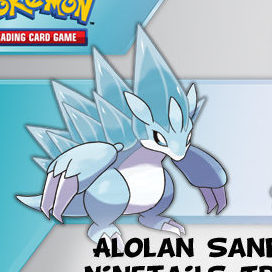

In [ ]:
image, label = train_dataset[100]
image
#len(train_dataset)

In [ ]:
# train_transform - augmentations
# test_transform - preprocessing images for input
normalize = T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])


train_transform = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    normalize,
])

test_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    normalize,
])

In [ ]:
#using test_transform for train_dataset first (without augmentations so far)

train_dataset = PokemonDataset(root = 'PokemonData', train=True, load_to_ram=False, transform=test_transform)
test_dataset = PokemonDataset(root = 'PokemonData', train=False, load_to_ram=False, transform=test_transform)



  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

In [ ]:
#using MobileNet_v2 without pre-trained weights and no augmentations
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights

num_epochs = 10

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = mobilenet_v2(num_classes = len(train_dataset.classes)).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

In [ ]:
#checking number of parameters
sum(param.numel() for param in model.parameters())

2416022

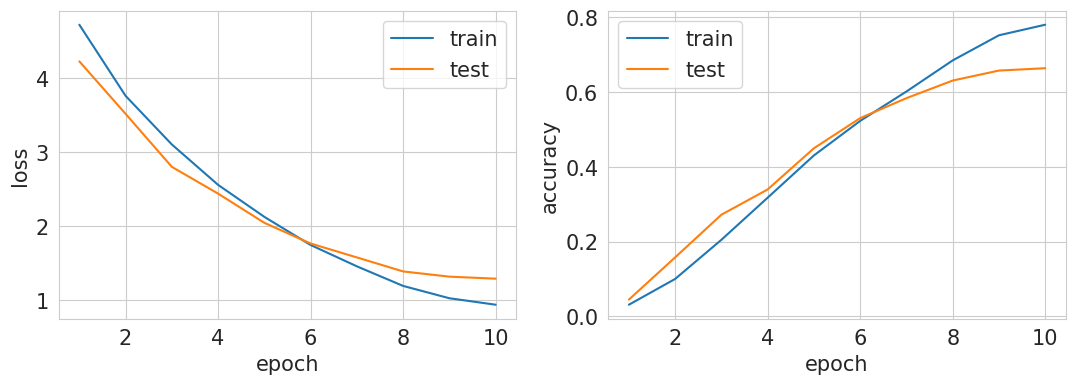

In [ ]:
train_losses, test_losses, train_accuracies, test_accuracies = train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs)

In [ ]:
#add augmentations for traing_dataset

train_dataset = PokemonDataset(root = 'PokemonData', train=True, load_to_ram=False, transform=train_transform)
test_dataset = PokemonDataset(root = 'PokemonData', train=False, load_to_ram=False, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

In [ ]:
#using MobileNet_v2 without pre-trained weights and with augmentations
num_epochs = 10

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = mobilenet_v2(num_classes = len(train_dataset.classes)).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

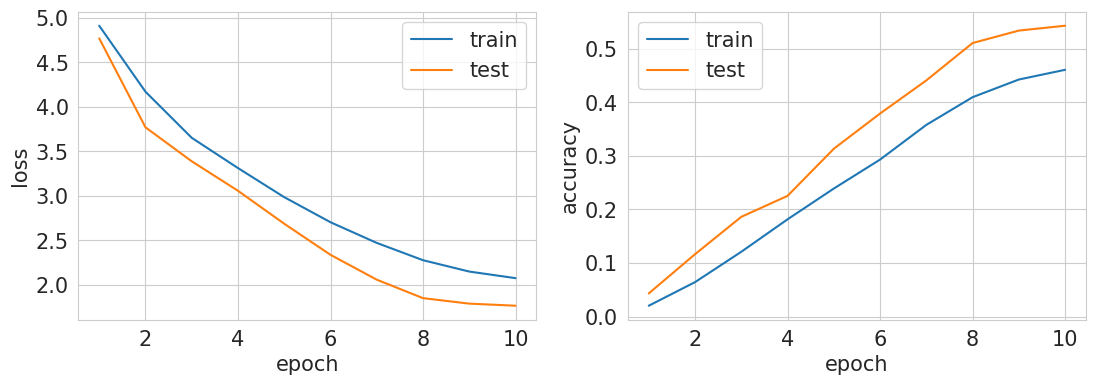

In [ ]:
train_losses, test_losses, train_accuracies, test_accuracies = train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs)

In [ ]:
#fine-tuning mobilenet_v2 with ImageNet weights

num_epochs = 10

model = mobilenet_v2(weights = MobileNet_V2_Weights.IMAGENET1K_V1)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 87.4MB/s]


In [ ]:
#changing head of mobilenet_v2 to our number of classes
model.classifier[1] = torch.nn.Linear(1280, len(train_dataset.classes))
model = model.to(device)


optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

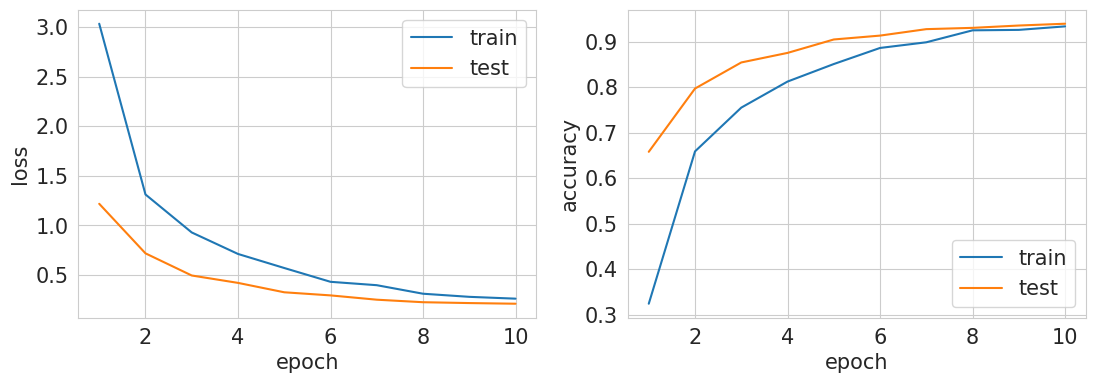

In [ ]:
train_losses, test_losses, train_accuracies, test_accuracies = train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs)

In [ ]:
#fine-tuning efficientnet_b0 with ImageNet weights

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

model = efficientnet_b0(weights = EfficientNet_B0_Weights)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model.classifier[1] = torch.nn.Linear(1280, len(train_dataset.classes))
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

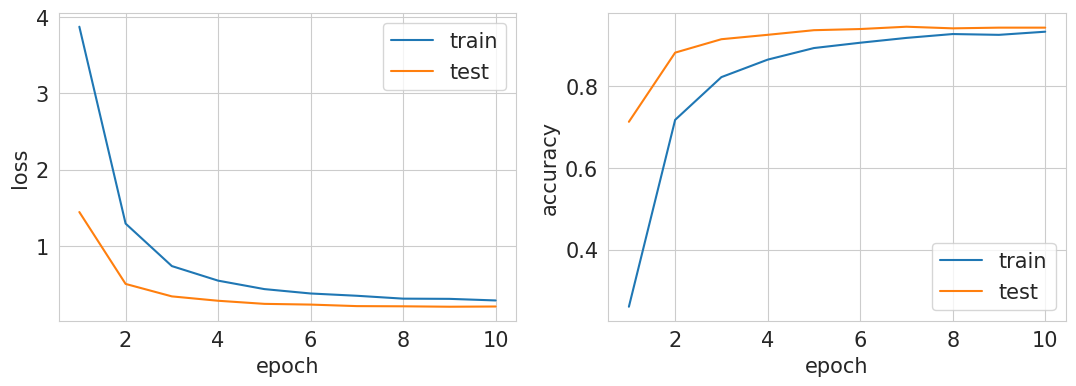

In [ ]:
train_losses, test_losses, train_accuracies, test_accuracies = train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs)

In [ ]:
#fine-tuning mnasnet0_5 with ImageNet weights

from torchvision.models import mnasnet0_5, MNASNet0_5_Weights

model = mnasnet0_5(weights = MNASNet0_5_Weights)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MNASNet0_5_Weights.IMAGENET1K_V1`. You can also use `weights=MNASNet0_5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model.classifier[1] = torch.nn.Linear(1280, len(train_dataset.classes))

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

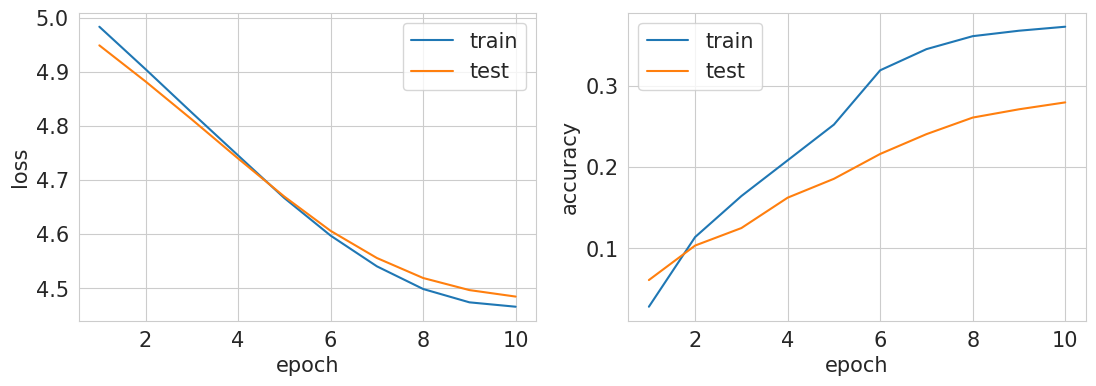

In [ ]:
train_losses, test_losses, train_accuracies, test_accuracies = train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs)

In [ ]:
#fine-tuning shufflenet_v2_x1_0 with ImageNet weights

from torchvision.models import shufflenet_v2_x1_0, ShuffleNet_V2_X1_0_Weights

model = shufflenet_v2_x1_0(weights = ShuffleNet_V2_X1_0_Weights)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#changing model.fc to our number of classes

model.fc = torch.nn.Linear(1024, len(train_dataset.classes))

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)



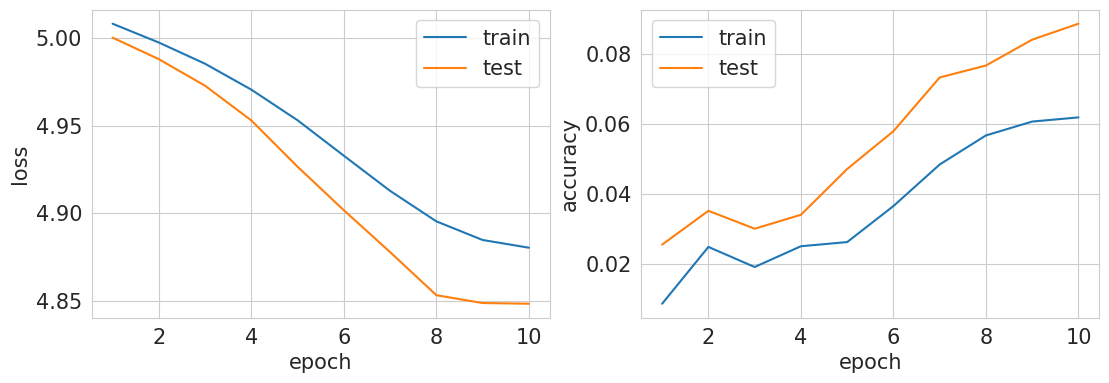

In [ ]:
train_losses, test_losses, train_accuracies, test_accuracies = train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs)

In [ ]:
#fine-tuning resnext50_32x4d with ImageNet weights

from torchvision.models import resnext50_32x4d, ResNeXt50_32X4D_Weights

model = resnext50_32x4d(weights = ResNeXt50_32X4D_Weights)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#changing model.fc to our number of classes

model.fc = torch.nn.Linear(2048, len(train_dataset.classes))

model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
criterion = torch.nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)



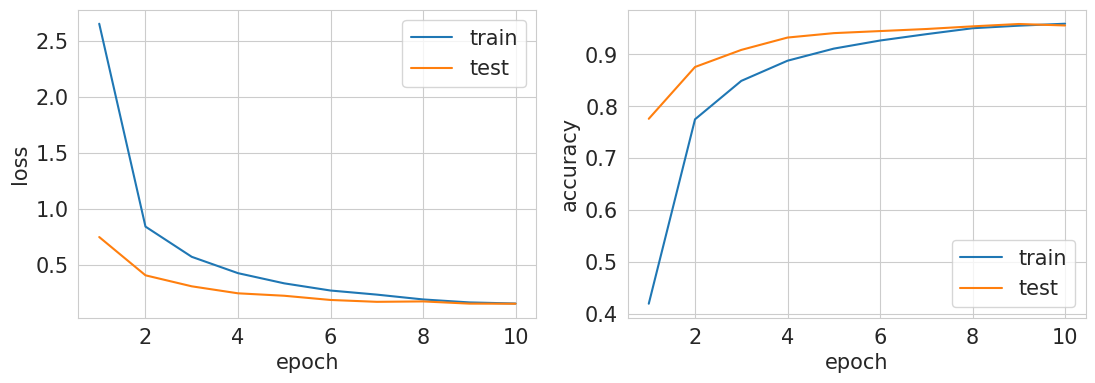

In [ ]:
train_losses, test_losses, train_accuracies, test_accuracies = train(model, optimizer, scheduler, criterion, train_loader, test_loader, num_epochs)